# Practice exercise II

In [1]:
import lux
import numpy as np
import pandas as pd
import quandl as qdl
import matplotlib.pyplot as plt

from sklearn import preprocessing, model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('bmh')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# LOAD DATA

qdl.ApiConfig.api_key = 'x9d-7DzcK7H4xMFVytLP'
h_data   = qdl.get('WIKI/AAPL', start_date='2015-01-01', end_date='2017-10-21')
f_data   = qdl.get('WIKI/AAPL', start_date='2017-10-21')

In [3]:
h_data.to_csv('apple_historical.csv')
f_data.to_csv('apple_future.csv')

In [4]:
h_apple = pd.read_csv('apple_historical.csv')
f_apple = pd.read_csv('apple_future.csv')

# Memo
h_apple_name = 'APPL tick 2015/01/01 - 2017/10/21'
f_apple_name = 'APPL tick 2017/10/21 - 2018/03/27'

In [5]:
eth = pd.read_csv('ethereum.csv', index_col=0)

In [6]:
eth

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

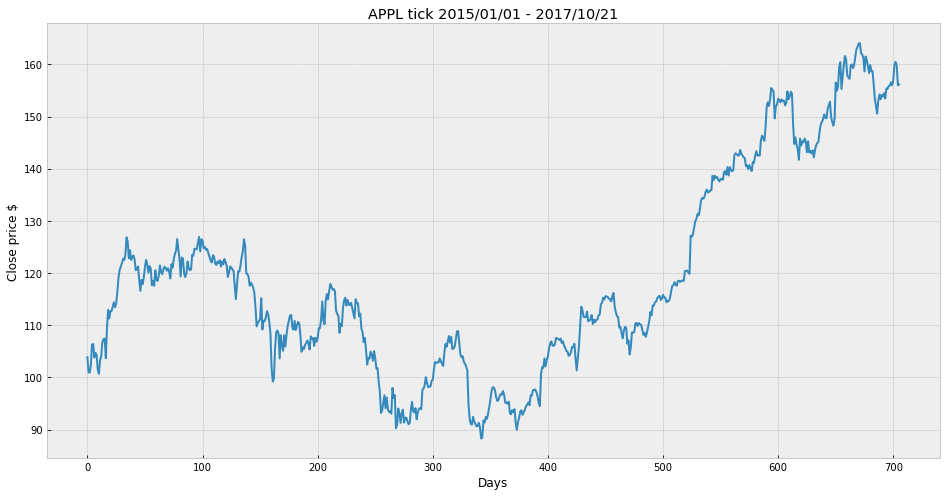

In [8]:
def simple_plot(data, name, x_label, y_label):
    plt.figure(figsize=(16,8))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(name)
    plt.plot(data)
    plt.show()
    
simple_plot(h_apple['Adj. Close'], 'APPL tick 2015/01/01 - 2017/10/21', 'Days', 'Close price $')

## Features engineering

In [9]:
h_df = h_apple[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

In [10]:
# for reusability purpose let make as a function
def percentage_change(dataframe):
    # High Low percentage change
    dataframe['HLP'] = (dataframe['Adj. High'] - dataframe['Adj. Low']) / (dataframe['Adj. Close'] )* 100
# Daily percentage change
    dataframe['DPC'] = (dataframe['Adj. Close'] - dataframe['Adj. Open']) / (dataframe['Adj. Open'] ) * 100 

In [11]:
percentage_change(h_df)
h_df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

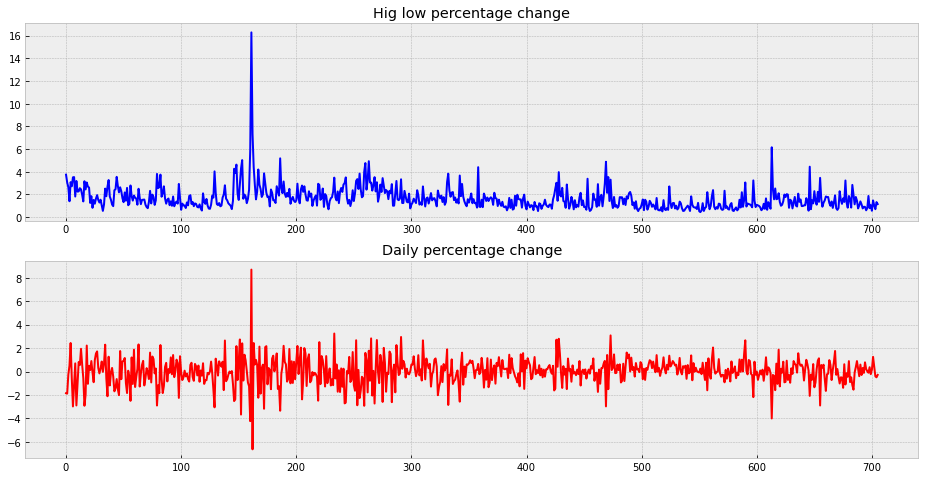

In [12]:
fig, ax = plt.subplots(2, figsize=(16, 8))
ax[0].plot(h_df['HLP'], c='b')
ax[0].set_title('Hig low percentage change')
ax[1].plot(h_df['DPC'], c='r')
ax[1].set_title('Daily percentage change')
plt.show()

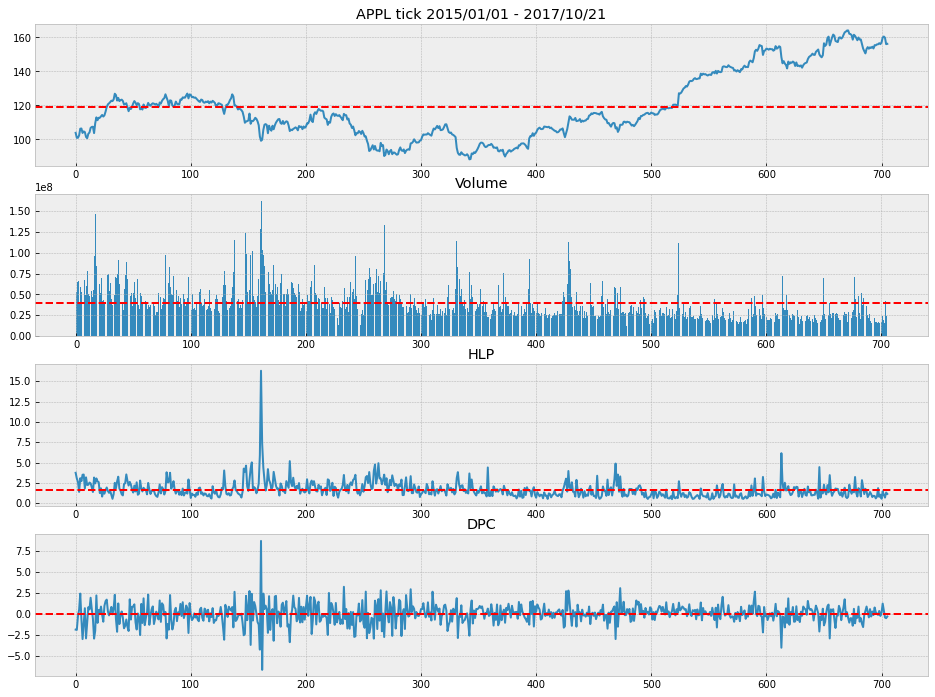

 mean volume :39824271.750708215
 mean  price :119.07487662230496
 mean  HLP   :1.673199158057583
 mean  DPC   :0.01941871584922549



In [13]:
%matplotlib inline

volume      = h_df['Adj. Volume']
close_price = h_df['Adj. Close']
HLP         = h_df['HLP']
DPC         = h_df['DPC']
mean_volume = np.mean(volume)
mean_price  = np.mean(close_price)
mean_HLP    = np.mean(HLP)
mean_DPC    = np.mean(DPC)

fig, axes = plt.subplots(4, figsize=(16, 12))

axes[0].plot(close_price)
axes[0].axhline(mean_price, color='r', linestyle='dashed')
axes[0].set_title(h_apple_name)
axes[1].bar(volume.index, volume)
axes[1].axhline(mean_volume, color='r', linestyle='dashed')
axes[1].set_title('Volume')
axes[2].plot(HLP)
axes[2].set_title('HLP')
axes[2].axhline(mean_HLP, color='r', linestyle='dashed')
axes[3].plot(DPC)
axes[3].set_title('DPC')
axes[3].axhline(mean_DPC, color='r', linestyle='dashed')
plt.show()

print(
    f' mean volume :{mean_volume}\n',
    f'mean  price :{mean_price }\n',
    f'mean  HLP   :{mean_HLP   }\n',
    f'mean  DPC   :{mean_DPC   }\n'
)

Maybe [volatily measure](https://www.investopedia.com/terms/v/volatility.asp) is good candidate for a feature ? 
<br>
Volatility is often measured as either the <code>**standard deviation or variance**</code> between returns from that same stock or market index.

 Step:
  * Find the mean of the data set
  * Calculate the difference between each data point value and the mean of set
  * Square the deviations
  * Add the squared deviations together
  * Divide the sum of the squared deviations by the number of data values
  * Sqr root them 

<div class="alert alert-block alert-success">

<h2> Statistics: Standard deviation </h2>

\begin{multline*}
\sigma = \sqrt{\dfrac{\sum_{i=1}^{m}(x_i - \overline{x})^2}{m - \text{ddof}}}
\end{multline*}

  * <code>**ddof**</code> delta degree of freedom, by default is 0. It depends what are we measuring, if it is a sample (subset) then ddof has a value of 1 if it is entire set then ddof is 0

</div>

In [14]:
def calculate_mean_mu_sigma(data, name):
    mu    = np.mean(data)
    sigma = np.std(data)
    cv    = sigma/mu
    print(
        f'  mean of {name}: {mu}\n',
        f' std  of {name}: {sigma}\n',
        f' cv   of {name}: {cv}'
    )

# volume
# close_price
# HLP
# DPC
calculate_mean_mu_sigma(close_price, 'price')

  mean of price: 119.07487662230496
  std  of price: 19.56358017536765
  cv   of price: 0.16429645556066044


<div class="alert alert-block alert-success">

<h2> Statistics: Coefficient of variation </h2>
    
Why do we need <code>**coefficient of variance (CV)**</code> ?<br>

\begin{multline*}
cv = \dfrac{\sigma}{\mu}
\end{multline*}

Standard deviation is the most common measure of variability for a single dataset. And coefficient of variances is a derivate of two other statistical measures. Lets say we have two simple datasets, we calcule the mean of each dataset. And standard deviations is going to be the same for both datasets because all Y is, is the X distribution just shifted up 100 points so in terms of <code>**spread**</code> of these two data sets they have to be same.<br>
But that is not the fully story of the <code>**spread**</code> , what happens if we thing about it this way : If we look at X data set within it we have an observation <code>**3**</code> which is in fact <code>**three times larger**</code> then 1. So in terms of scale of this X data set it varies quite a lot. <code>**It triples from the smallest to largerst value**</code>. The same can not be said for Y in term of the scale of this data set, 103 is just fractionally higher than 101. Thas why we need some other <code>**measure of variation**</code> that takes the scale of data set into account and where coefficient of variation comes into it

\begin{multline*}
X = 
\begin{bmatrix}
1, 2, 3
\end{bmatrix},
\mu = 2,
\sigma = 1,
cv = 0.5
\end{multline*} <br>

\begin{multline*}
Y = 
\begin{bmatrix}
101, 102, 103
\end{bmatrix},
\mu  = 102,
\sigma = 1,
cv = 0.0098
\end{multline*}
    
Coefficient of variation shows larger figure for X set but smaller for Y set. Simply what its doing is <code>**putting 
standard deviation into the scale of the data set, we are essentially scalling it by the sample mean**</code>
<br>
    
So it does show you something different than the standard deviation itself. Standard deviation is in absolute terms whereas the coefficient of variation is in proportionate terms, proportionate to the sample mean.

<h2>Example</h2>
    
Fuel prices (per litre) were surveyed every week for 5 weeks in the US and India. Which country experiences the 
<code>**greatest price fluctuations**</code> ? 
 
<table>
  <tr>
    <th>USA</th>
    <th>India</th>
  </tr>
  <tr>
    <td>2.50</td>
    <td>11500</td>
  </tr>
  <tr>
    <td>3.06</td>
    <td>12150</td>
  </tr>
    <tr>
    <td>2.80</td>
    <td>12950</td>
  </tr>
    <tr>
    <td>2.65</td>
    <td>13100</td>
  </tr>
      </tr>
    <tr>
    <td>2.75</td>
    <td>12500</td>
  </tr>
</table>   

If straight compare the means:
<table>
  <tr>
    <th>USA</th>
    <th>India</th>
  </tr>
  <tr>
    <td>2.752</td>
    <td>12,440</td>
  </tr>
</table>   

Standard deviation:

<table>
  <tr>
    <th>USA</th>
    <th>India</th>
  </tr>
  <tr>
    <td>0.1849</td>
    <td>577.40</td>
  </tr>
</table>  

Coeffcient of variation:

<table>
  <tr>
    <th>USA</th>
    <th>India</th>
  </tr>
  <tr>
    <td>0.0672</td>
    <td>0.0464</td>
  </tr>
</table>  

</div>

## Your ideas for features candidates

<code>**Some though directions**</code>
   - Time series analysis (trend)
   - SMA (simple moving average)
   - WMA (weighted moving average)

# WMA

In [15]:
close_price

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

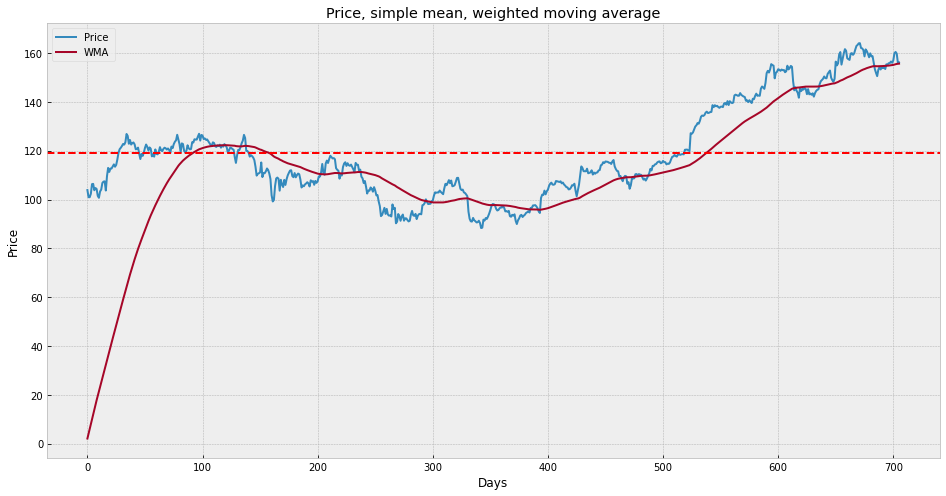

In [16]:
def wma(data, period):
    kernel = np.arange(period, 0, -1)
    kernel = np.concatenate([np.zeros(period - 1), kernel / kernel.sum()])
    return np.convolve(data, kernel, 'same')

h_df['wma'] = wma(close_price, 100)


plt.figure(figsize=(16, 8))
plt.title('Price, simple mean, weighted moving average')
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(h_df[['Adj. Close', 'wma']])
plt.axhline(mean_price, color='r', linestyle='dashed')
plt.legend(['Price ', 'WMA'])
plt.show()

One of feature candidate might be <code>**normal distribution (a.k.a Gaussian distribution)**</code> of volume if it give us as any insights ? <br>

To recap about normal distribution:
\begin{multline*}
f(x) = \frac{ 1 }{{\sigma \sqrt {2 \pi}}}e^{-\frac{\left({x - \mu} \right)^2}{2\sigma^{2}}}
\end{multline*}

NameError: name 'sigma' is not defined

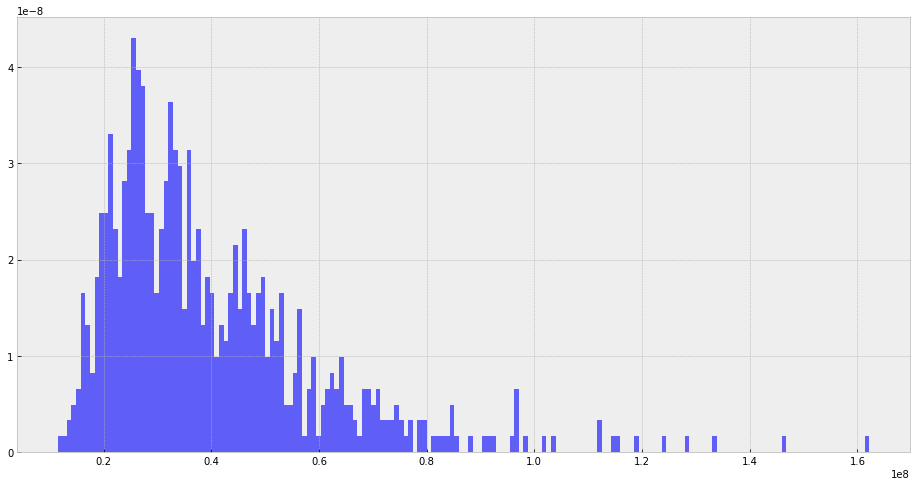

In [17]:
plt.figure(figsize=(16,8))
size = int(volume.size / 4)
# jupyter notebook trick
# plt.hist( - uncomment and when cursor is next to parenthesis press shift+tab
count, bins, _ = plt.hist(volume, bins=size, density=True, alpha=0.6, color='b')
gaussian_distribution = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp( - (bins - mu)**2 / (2 * sigma**2) )

plt.plot(bins, gaussian_distribution, linewidth=2, color='r')
plt.show()

We are mostly interested in deviants of the volume<code>**(market activity)**</code> norm because that represent the highest deviation and it means that something is going on we just don't know what exactly, yet.

<code>**NOTE!**</code><br> You might already see where this is going <br>

The more we move forward with analysis of stock market data it looks that it doesn't have that much linear relationship between dependenant (features like volume, date and so on) and independ variables (prices). So maybe rather of trying to predict continous output (price) we might predict signals like <code>**buy, sell, hold, take_a_break**</code> in a specific <code>**time intervals**</code>. These signals happens to be classes and thus we wil be dealing with <code>**multiclass classification.**</code> But for now lets keep on to see where can we get with multivariate linear regression model.

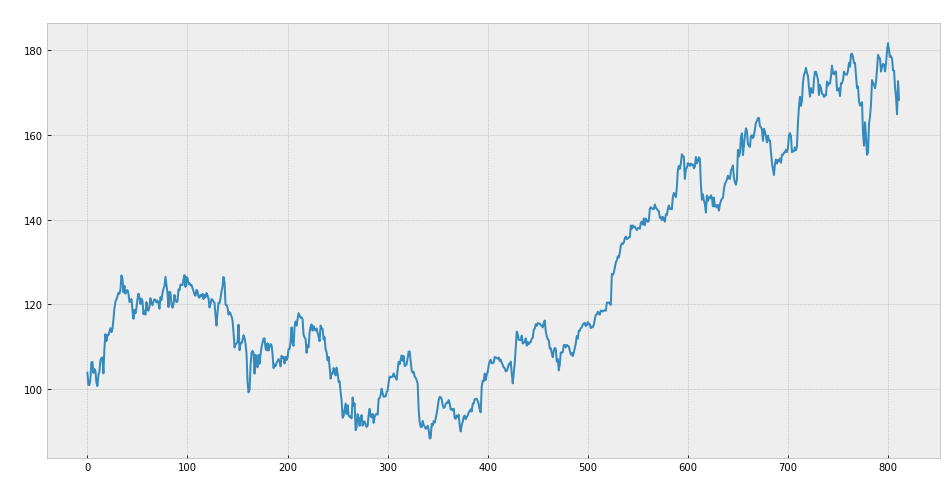

In [ ]:
eth = eth[['close','volume','hlp','dpc']]

In [ ]:
h_df = h_df[['Adj. Close', 'Adj. Volume', 'HLP', 'DPC']]
h_df

Some simple data checks to make sure that we don't have any missing values, anomalies.

In [ ]:
eth

In [ ]:
h_df.info()

In [ ]:
h_df.isna().sum()

In [ ]:
h_df.shape

In [ ]:
h_df.nunique()

In [ ]:
h_df['HLP']

In [ ]:
X = np.array(eth.drop(['close'], 1), dtype=np.object)
# labels(target) vector
y = np.array(eth['close'])

In [ ]:
# DESIGN (a.k a features) MATRIX and LABELS VECTOR

X = np.array(h_df.drop(['Adj. Close'], 1), dtype=np.object)
# labels(target) vector
y = np.array(h_df['Adj. Close'])

In [ ]:
h_df

In [ ]:
X

In [ ]:
# TEST
def test_size(a, b):
    print(f'X matrix shape: {a.shape}')
    print(f'y vector size: {b.shape}')
    if (len(a) == len(b)):
        print('we are good to go')
    else:
        print(f'lenght of X: {len(a)} \n')
        print(f'lenght of y: {len(b)}')
        
test_size(X, y)

This step depends on framework we are using, in sklearn case it's <code>**optial because LinearRegression() has parameter fit_intercept which by defaut is set to True, thus it handles for us x bias feature column**</code>

In [ ]:
# THIS STEP DEPENDS ON FRAMEWORK or METHOD we will use to fit our model to data
# x_0 = [1] * h_df.shape[0]
# h_df.insert(0,'x0', x_0)

Lecture about [Feature scaling](./__IV_Multiple_variables(multivariate)_linear_regression.ipynb)
<br>
Lecture about [Computing parameters analytically](./__V_Computing_parameters_analytically.ipynb)

<div class="alert alert-block alert-info">
<h2>Feature Scaling</h2>
    
We know certain things in advance from previous lectures that <code>**features must be scalled**</code> to find optimal coefficients without performance leaked. <br>
    <code>**Mean normalization, a.k.a 'standardization'**</code><br>
$$ x^{i} \leftarrow \dfrac{x^{i}- \mu_{x}}{\sigma_{x}}$$
 
* μ is mean of the x1 column
* σ is the range (max-min) of the x1 column or it can be standart deviation <br>

<code>**The reason why we need normalization is that the value of some features among all training examples may be much larger than the value of other features, which may make the cost function have pretty bad shape and this will make it harder for gradient descent to find the minimum. In order to solve this, we want to make all features have nearly the same scale, and make the range of the feature to be centered at zero.**</code><br>
    
BUT<br>    
<code>**Feature scaling is not necessary for the normal equation method. Reason being, the feature scaling is implemented to prevent any skewness in the contour plot of the cost function which affects the gradient descent but the analytical solution using normal equation does not suffer from the same drawback**</code>
</div>

In [ ]:
from sklearn import preprocessing

In [ ]:
X

In [ ]:
# SCALE
X_scaled = preprocessing.scale(X)

In [ ]:
X_scaled.shape

In [ ]:
print(X_scaled.mean(axis=0))
print(X_scaled.std(axis=0))

[preprocessing.scale()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html)<br>

<code>**with_mean, default=True**</code>
If True, center the data before scaling.
<br>
<code>**with_std , default=True**</code>
If True, scale the data to unit variance (or equivalently, unit standard deviation).

In [ ]:
X_sample = np.array([
    [1,  -1, 2],
    [2,  0,  0],
    [0,  1, -1]
])
X_scaled = preprocessing.scale(X_sample)
X_scaled

In [ ]:
print(X_scaled.mean(axis=0))
print(X_scaled.std(axis=0))

In [ ]:
x_0 = X_scaled[:,0]
x_1 = X_scaled[:,1]
x_2 = X_scaled[:,2]

In [ ]:
x_0_mean = np.mean(x_0)
x_1_mean = np.mean(x_1)
x_2_mean = np.mean(x_2)
print(
    f' x_0 mean: {x_0_mean}\n',
    f'x_1 mean: {x_1_mean}\n',
    f'x_2 mean: {x_2_mean}',
)

In [ ]:
x_0.size

In [ ]:
erdve = np.linspace(0, 10, 6)
print(erdve)

In [ ]:
space = np.linspace(0, x_0.size,int( x_0.size))

In [ ]:
X_test.shape

In [ ]:
def get_percentiles(d):
    return d.quantile(0.05), d.quantile(0.25), d.quantile(0.5), d.quantile(0.75), d.quantile(0.95)

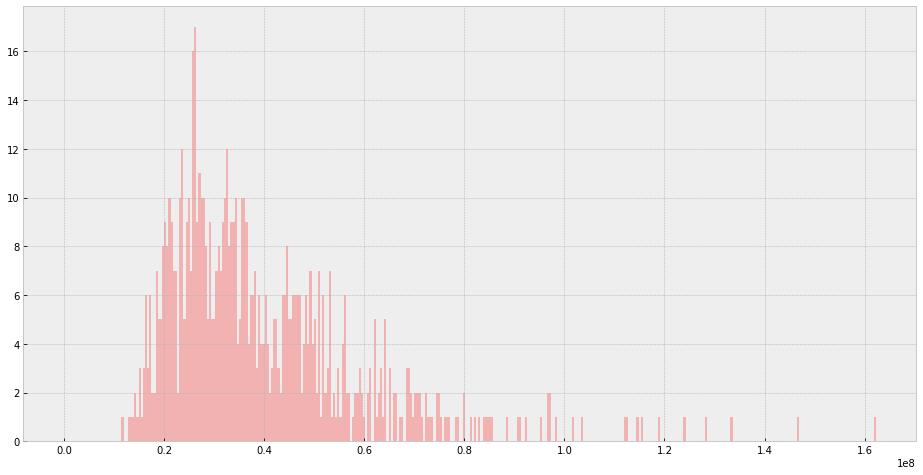

In [33]:
# fig, ax = plt.subplots(3, figsize=(16, 14))
# ax[0].scatter(space, x_0 ,c='b')
# ax[0].axhline(np.mean(x_0), color='r', linestyle='dashed')
# ax[1].scatter(space, x_1, c='g')
# ax[1].axhline(np.mean(x_1), color='r', linestyle='dashed')
# ax[2].scatter(space, x_2, c='r')
# ax[2].axhline(np.mean(x_2), color='r', linestyle='dashed')
# plt.show()




fig, ax = plt.subplots(figsize = (16,8))
X_test = h_df.drop(['Adj. Close'], 1)
X_scaled = preprocessing.scale(X_test)
vol_col = X_test['Adj. Volume']
scaled_vol_col=X_scaled[:,0]
q_5, q_25, q_50, q_75, q_95 = vol_col.quantile(0.05), vol_col.quantile(0.25), vol_col.quantile(0.5), vol_col.quantile(0.75), vol_col.quantile(0.95)
quants = [[q_5, 0.6, 0.16], [q_25, 0.8, 0.26], [q_50, 1, 0.36],  [q_75, 0.8, 0.46], [q_95, 0.6, 0.56]]

# KDE will only work if we change the y axis from absolute values to density values
# 

plt.hist(vol_col, color='red' ,bins=353, alpha=0.25 )
plt.hist(scaled_vol_col, color='blue', bins=353)
# plt.hist([vol_col, scaled_vol_col], bins=353)
plt.show()

In [36]:
print(scaled_vol_col.max())

2.33469100092473


## Just to recap:

<code>**Normal equation**</code><br>
\begin{multline*}
\theta = (X^{\top}X)^{-1} X^{\top}y
\end{multline*}

<br>


<code>**Gradient descent**</code><br>
\begin{multline*}
\theta_{j}:= \theta_{j} - \alpha \dfrac{\partial}{\partial\theta_{j}} J(\theta_{0}, \theta_{1}, ...,\theta_{m})
\end{multline*}

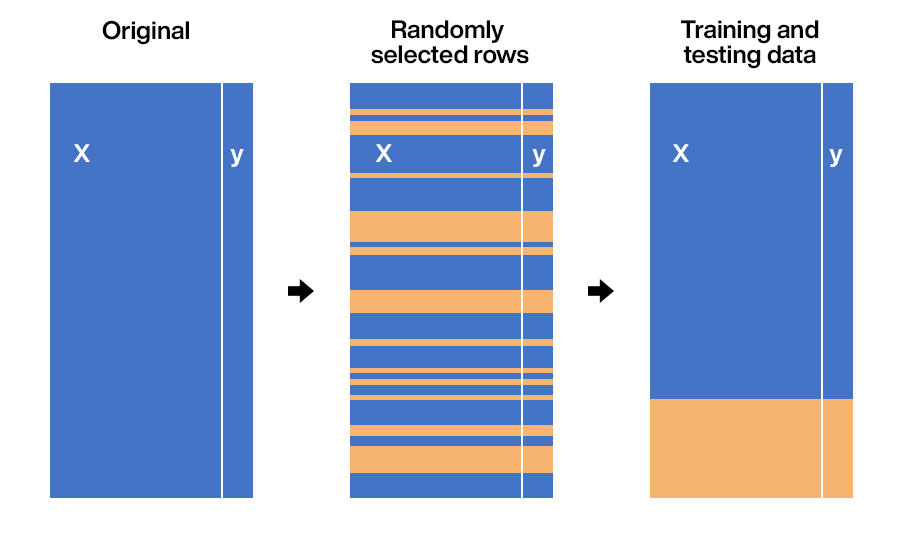

In [53]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
print('lengths of X_train and X_test: ', len(X_train), len(X_test))

NameError: name 'X' is not defined

In [ ]:
test_size(X_train, y_train)

In [ ]:
# default parameter fit_intercept=True
model = LinearRegression() #DecisionTreeRegressor() #SGDRegressor() #LinearRegression()
# learn 
model.fit(X_train, y_train)

Metrics lecture [VIII_Metrics_overview](__VIII_Metrics_overview.ipynb)

We are going to use inbuilt regression score function (R² coefficient of determination) in <code>**LinearRegression()**</code>
[linear_model.score](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score)

\begin{multline*}
R^{2} = 1- \dfrac{\sum_{i=1}^{m}(y_{i} - \hat{y}_{i})^{2}}{\sum_{i=1}^{m}(y_{i} - \overline{y})^{2}}
\end{multline*}



In [ ]:
# Return R² of the prediction.
r2_test  = model.score(X_test, y_test)
r2_train = model.score(X_train, y_train) 
# Theta coefficients
coef      = model.coef_ 
# Interceptor
intercept = model.intercept_
print(f'R² tests: {np.around(r2_test , 4 )}')
print(f'R² train: {np.around(r2_train , 4 )}')
print(f'coef: {coef}') 
print(f'intercept:{intercept}')

$$h_{\theta}(x) = \theta_{0}x_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \theta_{3}x_{3}$$<br>

Manual way to calculate R² score <code>**(for recap purpose):**</code>

In [ ]:
def r2(y_true, y_pred):
    y_mean = y_true.mean()
    SS_res = ((y_true - y_pred) ** 2).sum()
    SS_tot = ((y_true - y_mean) ** 2).sum()
    return 1 - (SS_res/SS_tot)

In [ ]:
X_test.shape

In [ ]:
y_predictions = model.predict(X_test)

In [ ]:
X_test.shape

In [ ]:
y_predictions

In [ ]:
print(f'y test vector shape{y_test.shape}')
print(f'y predictions vector shape{y_predictions.shape}')

In [ ]:
print(r2(y_test, y_predictions))

## Practice exercise
Manual way to calculate predictions(y) on give features(X), model coefficients can be extract with<code>**model.coef_**</code> <code>**(for recap purpose):**</code>

In [ ]:
def hypothesis(xs):
    pass

def predict(xs):
    pass

predict(X_test)

## Future data extraction 

In [ ]:
y_future = f_apple['Adj. Close']
y_future

In [ ]:
f_df = f_apple[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
f_df

In [ ]:
percentage_change(f_df)
f_df

In [ ]:
f_df = f_df[['Adj. Close', 'Adj. Volume', 'HLP', 'DPC']]

In [ ]:
X_future = np.array(f_df.drop(['Adj. Close'], 1), dtype=np.object)
y_future = np.array(f_df['Adj. Close'])

In [ ]:
X_future = preprocessing.scale(X_future)
y_predict = model.predict(X_future)

In [ ]:
r2_val = model.score(X_future, y_future) 
print(f'accuracy with validation: {r2_val}')

Lets plot it 

In [ ]:
f_df['predictions'] = y_predict

In [ ]:
# VISUALIZE
%matplotlib inline
plt.figure(figsize=(18, 8))
plt.title('Model')
plt.xlabel('Days')
plt.ylabel('Close price $')
plt.plot(f_df[['Adj. Close', 'predictions']])
plt.legend(['Original', 'Predicted'])
plt.show()

## DRAFT NOT LECTURE MATERIAL

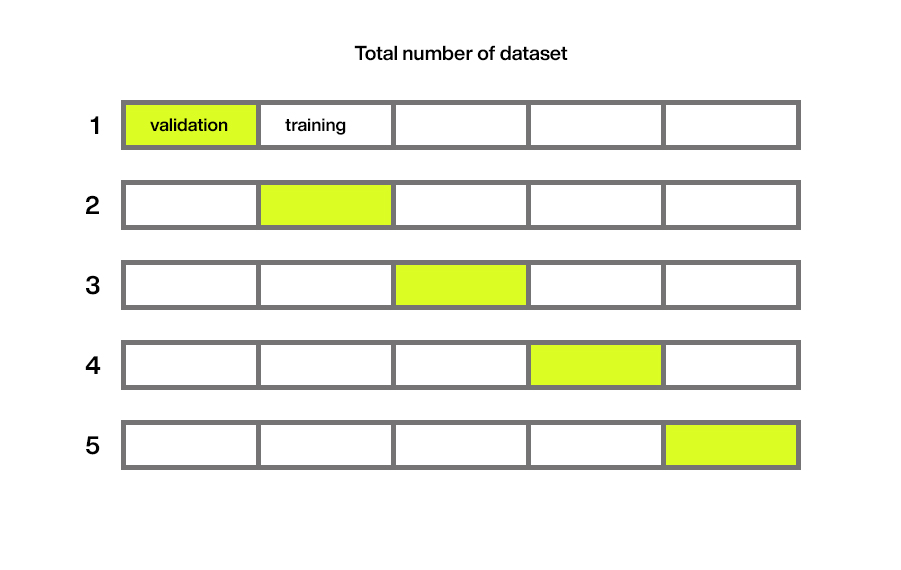

In [ ]:
# cross validation

from sklearn.model_selection import cross_validate
scores = cross_validate(model, X, y, cv=5, scoring=('r2',))
entries = sorted(scores.keys())
print(entries)
print(scores['test_r2'])

In [ ]:
# FORMAT DATA
valid = nflx[X.shape[0]:]
valid['predictions'] = predict
valid.tail()

In [ ]:
# VISUALIZE
%matplotlib inline
plt.figure(figsize=(18, 8))
plt.title('Model')
plt.xlabel('Days')
plt.ylabel('Close price $')
plt.plot(nflx['Adj. Close'], c='r')
plt.plot(valid[['Adj. Close', 'predictions']])
plt.legend(['Original', 'Valid', 'Predicted'])
plt.show()

## DRAFT MATERIAL ! 

In [ ]:
LASO  - L1 Regularization  / penalty for high value coefficients
RIDGE - L2 Regularization  / "Squared magnitude"
Elasctic net - combo of both 



In [ ]:
# Coefficients
# l_reg_coef = pd.DataFrame()
# l_reg_coef['Columns'] = X_train.columns
# l_reg_coef['Coefficient estimate'] = pd.Series(model.coef_)
# fig, ax = plt.subplots(figsize=(16, 8))
# color = [
#     'tab: gray',
#     'tab: blue',
#     'tab: orange',
#     'tab: green',
#     'tab: red',
#     'tab: purple'
# ]
# ax.bar(l_reg_coef['Columns'], l_reg_coef['Coefficient estimate'], color = color)
# ax.spines['bottom'].set_position('zero')
# plt.show()


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.25, random_state=2)
print('length of X_train and x_test: ', len(X_train), len(X_test))

In [ ]:
model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=4)),
    ('regressor', LinearRegression())
    #DecisionTreeRegressor() #SGDRegressor() #LinearRegression()
])

model.fit(X, y)
score  = model.score(X_test, y_test)
predict = model.predict(x_future)
print(score)
print(predict)

In [ ]:
valid = nflx[X.shape[0]:]
valid['predictions'] = predict
valid.tail()

In [ ]:

plt.figure(figsize=(18, 8))
plt.title('Model')
plt.xlabel('Days')
plt.ylabel('Close price $')
plt.plot(nflx['Adj. Close'], c='r')
plt.plot(valid[['Adj. Close', 'predictions']])
plt.legend(['Original', 'Valid', 'Predicted'])
plt.show()

In [ ]:
sorted(x_future[0,:])

In [ ]:
sorted(y_pred)

In [ ]:
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.plot(nflx['Adj. Close'])


# MEMO NOT: do slice FIX  

plt.plot(sorted(x_future[-future:, 0]), y_pred[np.argsort(x_future[-future:, 0])], 'r')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
def plot_lcs(model, X, Y, val_split=0.25, metrics=mean_squared_error):  
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=val_split) 
    # collections of errors:
    train_time_loss, test_time_loss = [], []   
    # iterating over train size:
    for train_size in range(1, len(x_train)):
        # training
        model.fit(x_train[:train_size], y_train[:train_size])
        
        # train and val predictions
        train_preds = model.predict(x_train[:train_size])
        test_preds = model.predict(x_test)
        
        # metrics calculation
        train_time_loss.append(metrics(y_train[:train_size], train_preds))
        test_time_loss.append(metrics(y_test, test_preds))
        
    # plotting curves
    plt.figure(figsize=(14, 6))
    plt.plot(np.sqrt(train_time_loss), 'r-*', label='Train loss')
    plt.plot(np.sqrt(test_time_loss), 'b-+', label='Test loss')
    plt.legend()
    plt.ylabel(f'{metrics.__name__}')
    plt.xlabel('Training Set Size')

In [ ]:
models = {
    'tree': Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('regressor', LinearRegression())
])
#     'lnr' : Pipeline([
#     ('poly_features', PolynomialFeatures()),
#     ('regressor', LinearRegression())
# ]),
#     'sgd' : Pipeline([
#     ('poly_features', PolynomialFeatures()),
#     ('regressor', SGDRegressor())
# ])
}

metrics = mean_square_error
for key, model in models.items():
    plot_lcs(model, X, y, metrics=metrics)

In [ ]:
#Regularization L1

# from sklearn import linear_model
# lasso_reg = linear_model.Lasso(alpha=5, max_iter=25, tol=0.05)
# lasso_reg.fit(X_train, y_train)
# accuracy_tr = lasso_reg.score(X_test, y_test)
# accuracy_te = lasso_reg.score(X_train, y_train) 
# # Theta coefficients
# coef  = lasso_reg.coef_ 
# # Interceptor
# print(f'accuracy with tests: {accuracy_tr}')
# print(f'accuracy with train: {accuracy_te}')
# print(f'coef: {coef}') 